<a href="https://colab.research.google.com/github/maskaljunas/Affective_Signals/blob/main/affectiveSignalsHeartBeat_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Affective signals IIII
----
<span style="color:Blue">**Through this notebook we hope you get an hands on approach to the seminar. 
    Below you will find code snippets and theory that will help you apply the various libraries that have been introduced to you in the course.**</span>

In [ ]:
! apt-get install cmake gfortran

In [ ]:
# the installation takes around 15 minutes
! pip install pyvhr==0.0.4

In [ ]:
! pip install --upgrade tensorflow==2.2.0
! pip install --upgrade tensorflow-gpu

In [ ]:
! pip install hrv-analysis

In [7]:
# mount your Google Drive, where your video is located

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import collections

from pyVHR.signals.video import Video
from pyVHR.methods.pos import POS
from pyVHR.methods.chrom import CHROM
from pyVHR.analysis.testsuite import TestSuite, TestResult


# In this Notebook we want to analyse heart rate related data from your prerecorded videos. Since we do not have ECG recordings, this will be estimated based on remote photoplethysmography (rPPG) using the [pVHR](https://github.com/phuselab/pyVHR) package (version=0.0.4). 


### **The Tasks for this sheet will be an open task meaning you will have to think about what statistical aspects you want to look at for a particular feature. (At least one as you did for the previous Notebooks)**


###ECG, PPG and rPPG Signal

The ECG signal is directly derived from the electrical signal caused by the heart and produces this specific signal pattern shown in the following figure. 

PPG methods also have direct contact with the skin, however do not measure electrical signals but infra-red light reflections from the skin. The reflection varies depending on how much blood volume is present at a specific time in the tissue. 
Hence, PPG reflects a pulse signal with a different signal pattern than ECG. Both signals are highly correlated and can be analysed to some part the same way. 





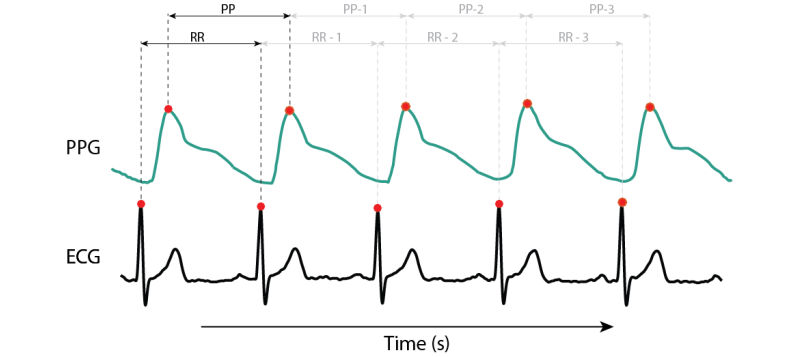[Source](https://www.empatica.com/blog/the-clinical-importance-of-heart-rate-variability.html)

###rPPG 


Remote PPG measures the variance of red, green and blue light reflections changes from the skin (specular reflection and diffused reflection). 
Specular reflection is the light reflection from the skin surface, which is modulated by motion and the skin surface itself. Diffuse reflection, in contrast, contains pulsatile information. It reflects absorption and scattering in skin tissue, which depends on blood volume changes. 
[Source](https://ieeexplore.ieee.org/abstract/document/7565547)



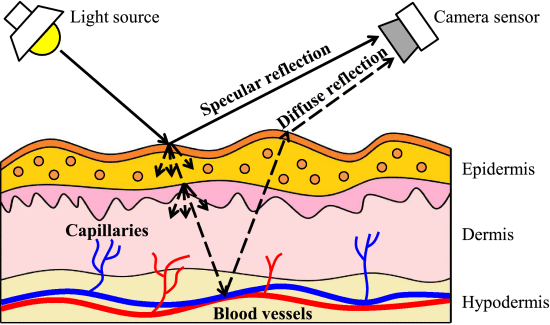


####rPPG
The rPPG signal slightly differs in its pattern compared to classical PPG signal but reflect the same information of blood volume pulse (BVP). 

Blood volume pulse is the volume of blood that passes through the vessels in an area with each beat of the heart (pulse).
The PPG signal (also rPPG) and BVP are similar measurements, meaning that the BVP signal results from high-pass filtering the PPG signal.

BVP peaks correspond with the R peaks of the ECG signal and hence can be used for heart rate variability (HRV) or in this case pulse rate variability (PRV) analysis.

The following figure shows their signal relationship: ECG-GT is the ground truth signal compared with rPPG. 

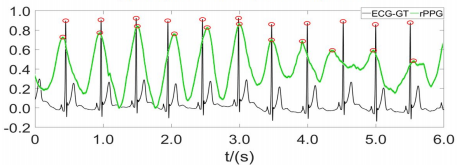
[Source](https://ieeexplore.ieee.org/document/9010965)

# [pyVHR](https://github.com/phuselab/pyVHR)

pyVHR stands for Python framework for Virtual Heart Rate and estimates beats per minute (bpm) by using the RGB-video data. A short overview of the framework is shown in the following figure. 

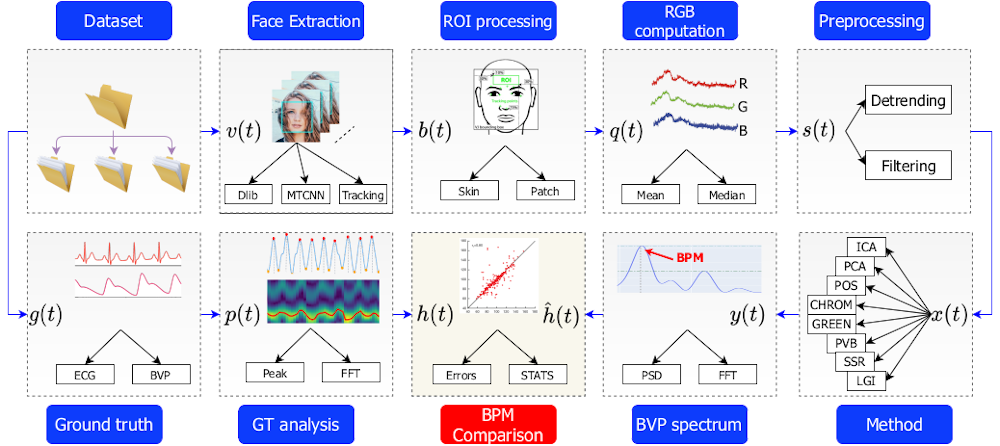

First, we need to extract cropped face images from the video by using a pretrained face detection model: 

Additionally, you get some general information about your video file.

Note: depending on how long the video is, it will take up to 20 minutes.

In [ ]:
from pyVHR.signals.video import Video

# -- Video object
videoFilename = "/content/drive/video.mp4"  # location of your video
video = Video(videoFilename)

# -- extract faces
video.getCroppedFaces(detector='mtcnn', extractor='opencv')
video.printVideoInfo()


Visualize the cropped face:


In [ ]:
print("\nShow video cropped faces, crop size:", video.cropSize)
video.showVideo()

In [ ]:
# -- define ROIs: using skin, with threshold param 
video.setMask(typeROI='skin_adapt',skinThresh_adapt=0.2)
video.printROIInfo()
video.showVideo()

The framework uses different well-known rPPG methods (e.g. [POS](https://ieeexplore.ieee.org/document/7565547), [CHROM](https://ieeexplore.ieee.org/document/6523142), [Green](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2717852/), [PBV](https://pubmed.ncbi.nlm.nih.gov/25159049/) ) to estimate the respective blood volume pulse from RGB values, from which the bpm can be derived. 

First, the raw RGB data is preprocessed in order to suppress noise and artifacts. 

Then, the preprocessed signal is split into overlapped subsequences (chunks) in order to estimate a temporal sequence, the blood volume pulse (BVP), based on the respective rPPG method.

The BVP signal of the respective chunks is used to calculate bpm. Spectral analysis, in this case, Power Spectral Density (PSD) is performed to evaluate the power distribution as a function of frequency, hence to get the underlying bpm frequency.  




Apply different methods to compare the resulting difference in bpm estimation:

In [12]:
# -- apply remote PPG method

from pyVHR.methods.pos import POS
from pyVHR.methods.ssr import SSR
from pyVHR.methods.pbv import PBV
from pyVHR.methods.chrom import CHROM
from pyVHR.methods.green import GREEN

# fine tuning
params = {"video": video, "verb":1, "ROImask":"skin_adapt", "skinAdapt":0.2}

# different methods
pos = POS(**params)
ssr = SSR(**params)
pbv = PBV(**params)
mchrom = CHROM(**params)
mgreen = GREEN(**params)

# -- get BPM values
bpmES_pos, timesES_pos = pos.runOffline(**params)
bpmES_pbv, timesES_pbv = pbv.runOffline(**params)
bpmES_green, timesES_green = mgreen.runOffline(**params)
bpmES_chrom, timesES_chrom = mchrom.runOffline(**params)


    * POS params: start time = 0.0, end time = 43.5, winsize = 5.0 (sec)

    * PBV params: start time = 0.0, end time = 43.5, winsize = 5.0 (sec)

    * GREEN params: start time = 0.0, end time = 43.5, winsize = 5.0 (sec)

    * CHROM params: start time = 0.0, end time = 43.5, winsize = 5.0 (sec)


Visualize the different bpm estimation methods:

The average heart rate is 94.73211115056819


Text(0.5, 1.0, 'Method - Chrom')

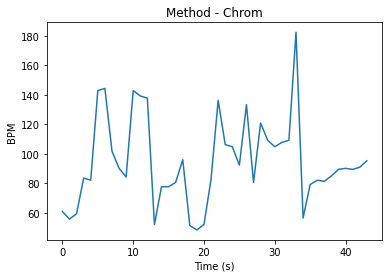

In [13]:
print(f"The average heart rate is {np.average(bpmES_chrom[0])}")
plt.plot(timesES_chrom,bpmES_chrom[0][:])
plt.ylabel("BPM")
plt.xlabel("Time (s)")
plt.title('Method - Chrom')

The average heart rate is 74.4906338778409


Text(0.5, 1.0, 'Method - GREEN')

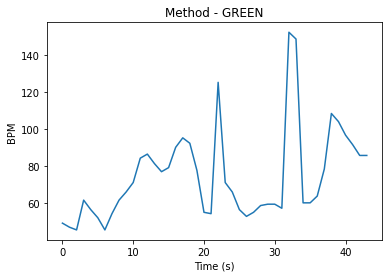

In [14]:
print(f"The average heart rate is {np.average(bpmES_green[0])}")
plt.plot(timesES_green,bpmES_green[0][:])
plt.ylabel("BPM")
plt.xlabel("Time (s)")
plt.title('Method - GREEN')

The average heart rate is 81.34876598011364


Text(0.5, 1.0, 'Method - POS')

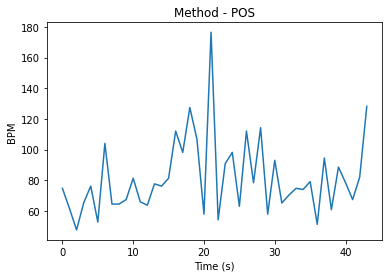

In [15]:
print(f"The average heart rate is {np.average(bpmES_pos[0])}")
plt.plot(timesES_pos,bpmES_pos[0][:])
plt.ylabel("BPM")
plt.xlabel("Time (s)")
plt.title('Method - POS')

The average heart rate is 82.03125


Text(0.5, 1.0, 'Method - PVB')

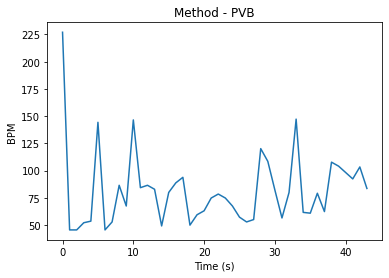

In [16]:
print(f"The average heart rate is {np.average(bpmES_pbv[0])}")
plt.plot(timesES_pos,bpmES_pbv[0][:])
plt.ylabel("BPM")
plt.xlabel("Time (s)")
plt.title('Method - PVB')

As you notice, the heart rate estimation with rPPG is very sensitive and highly prone to outliers, if not measured in a controlled setting. This is due to motion artifacts, bad light conditions and camera quality settings. 
**Hence, be cautious in the interpretation of the estimated heart rate and its resulting parameters.**

# **Task 4.1**

 **Analysis of heart rate**

Have a look at your heart rate over time and evaluate if the estimation makes sense. If not, apply filtering or outlier detection methods.
Try to analyse interesting aspects of the heart rate, try to combine your analysis with previous finding of the other notebooks.

In [ ]:
#your code goes here:


### RGB, BVP, bpm

This part will visualize the raw and preprocessed RGB data, its respective BVP signal and the resulting heart rate:


In [17]:
from pyVHR.utils import filters
from pyVHR.utils import printutils
from pyVHR.signals import bvp

verb = params['verb']
startTime = 0
endTime=np.Inf
winSize = 5
timeStep = 1
zeroMeanSTDnorm = 0
BPfilter = 1
minHz = .75
maxHz = 4.
detrending = 0
detrLambda = 10
detrMethod = 'tarvainen'
fs = video.frameRate

# -- check times
if endTime > video.duration:
    endTime = video.duration
assert startTime <= endTime, "Time interval error!"
assert timeStep > 0, "Time step must be positive!"
assert winSize < (endTime-startTime),"Winsize too big!"

timeSteps = np.arange(startTime,endTime,timeStep)
T = startTime    # times where bpm are estimated
RADIUS = winSize/2

bpmES = []     # bmp estimtes
timesES = []   # times of bmp estimtes

# -- loop on video signal chunks
startFrame = int(T*video.frameRate)
count = 0

bvpChunks = []
xChunks = []

while T <= endTime:
  endFrame = np.min([video.numFrames, int((T+RADIUS)*video.frameRate)])

  # -- extract ROIs on the frame range
  frameSubset = np.arange(startFrame, endFrame)
  ROImask = params['ROImask']

    # -- type of signal extractor
  if ROImask == 'skin_adapt':
      video.setMask(ROImask, skinThresh_adapt=float(params['skinAdapt']))

  video.extractSignal(frameSubset, count)

  # -- RGB computation
  RGBsig = video.getMeanRGB()

  # -- print RGB raw data
  printutils.multiplot(y=RGBsig, name=['ch B', 'ch R','ch G'], title='RGB raw data')

  # -- RGBsig preprocessing
  if BPfilter:
      RGBsig = filters.BPfilter(RGBsig, minHz, maxHz, fs)

  # -- print postproce
  printutils.multiplot(y=RGBsig, name=['ch B', 'ch R','ch G'], title='RGB postprocessing')

  # -- apply the selected method to estimate BVP
  # use method selected
  rPPG = GREEN.apply(_, RGBsig)
              
  # BVP postprocessing 
  startTime = np.max([0, T-winSize/video.frameRate])
  bvpChunk = bvp.BVPsignal(rPPG, video.frameRate, startTime, minHz, maxHz, verb)

  # -- estimate BPM by PSD
  bvpChunk.PSD2BPM(chooseBest=True)

  c,n = bvpChunk.data.shape
  stopTime = bvpChunk.startTime+n/bvpChunk.fs
  x = np.linspace(bvpChunk.startTime, stopTime, num=n, endpoint=False)

  # BVP signal 
  bvpChunk.plot()

  bvpChunk.findPeaks()

  # -- save the estimate
  bpmES.append(bvpChunk.bpm)
  timesES.append(T)

  # -- define the frame range for each time step            
  T += timeStep
  startFrame = np.max([0, int((T-RADIUS)*video.frameRate)])

  count += 1
  xChunks.append(x)
  bvpChunks.append(bvpChunk)

bpm = np.array(bpmES).T

To understand how the heart rate is derived from the blood volume signal, you can calculate this for every signal chunk by performing spectral analysis. [Power spectral density](https://en.wikipedia.org/wiki/Spectral_density) displays at which frequencies the variations are strong and where they are weak. The strongest frequency represents the heart rate for the BVP signal.  

In [18]:
# first 5 chunks
for i in range(5): #len(bvpChunks)):
  print('Bpm estimation for the respective chunk: ', bvpChunks[i].bpm)
  bvpChunks[i].plotBPMPeaks()
  print('Power spectral density for BVP signal')
  print('X-axis - Hz')
  print('Y-axis - Count')
  bvpChunks[i].displayPSD()

Bpm estimation for the respective chunk:  [49.07226562]


Power spectral density for BVP signal
X-axis - Hz
Y-axis - Count


Bpm estimation for the respective chunk:  [46.875]


Power spectral density for BVP signal
X-axis - Hz
Y-axis - Count


Bpm estimation for the respective chunk:  [45.41015625]


Power spectral density for BVP signal
X-axis - Hz
Y-axis - Count


Bpm estimation for the respective chunk:  [61.5234375]


Power spectral density for BVP signal
X-axis - Hz
Y-axis - Count


Bpm estimation for the respective chunk:  [56.39648438]


Power spectral density for BVP signal
X-axis - Hz
Y-axis - Count


# HRV and PRV

Heart rate variability (HRV) is the variation in the time interval between adjacent heart beats (R peaks), and is modulated by various factors as seen in the seminar. The main physiological modulators are sympathicus and parasympathicus, which either increase the heart rate and lowers the RR variability (low HRV) or decrease the heart rate and increase the RR variability (high HRV).



Pulse Rate Variability (PRV) is the variation in the time interval between adjacent heart beats based on its blood volume pulse and is highly correlated with HRV. [Source](https://ieeexplore.ieee.org/abstract/document/7591347) 



In [19]:
# calculate inter-pulse-intervals
bvp_peakTimes = []
for i in range(0, len(bvpChunks)):
  c,n = bvpChunks[i].data.shape
  stopTime = bvpChunks[i].startTime+n/bvpChunks[i].fs
  x = np.linspace(bvpChunks[i].startTime, stopTime, num=n, endpoint=False)
  bvp_peakTimes.append(x[bvpChunks[i].peaks])

bvp_peakTimes_signal = np.concatenate(bvp_peakTimes).ravel()
bvp_peakTimes_signal = np.round(bvp_peakTimes_signal,3)

# take duplicates from peak estimation due to overlapping signal
bvp_peakTimes_filtered = [item for item, count in collections.Counter(bvp_peakTimes_signal).items() if count > 1]
bvp_peakTimes_filtered = np.sort(bvp_peakTimes_filtered)

# inter pulse interval
ppi  = [x - bvp_peakTimes_filtered[i - 1] for i, x in enumerate(bvp_peakTimes_filtered)][1:]
# convert to ms
ppi = [element * 1000 for element in ppi]


Text(0.5, 1.0, 'Rhythmogram: PP Intervals')

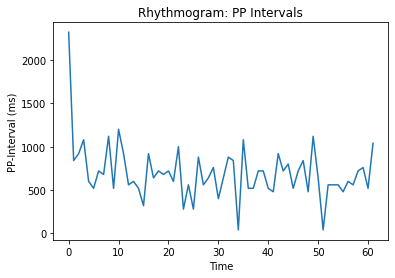

In [20]:
# Rhythmogram: Visualize PP intervals
plt.plot(ppi)
plt.xlabel('Time')
plt.ylabel('PP-Interval (ms)')
plt.title('Rhythmogram: PP Intervals')

Text(0.5, 1.0, 'PP interval histogram')

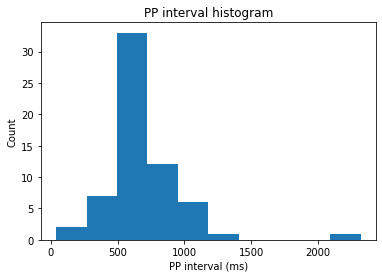

In [21]:
# PP interval histrogram visualization
plt.hist(ppi)
plt.xlabel('PP interval (ms)')
plt.ylabel('Count')
plt.title('PP interval histogram')

In [22]:
# outlier filtering

# remove PP intervals which are smaller than 300 ms and bigger than 2s (both are physiological impossible and unlikely)
# use the histogram also for outlier detection
ppi = [element for element in ppi if  2000> element >300]

Text(0.5, 1.0, 'Rhythmogram: PP Intervals filtered')

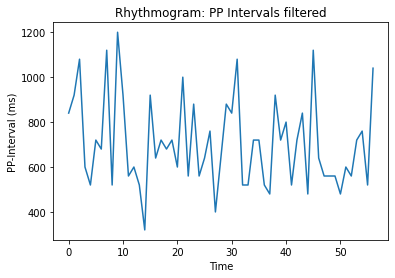

In [23]:
# Rhythmogram: Visualize filtered PP intervals
plt.plot(ppi)
plt.xlabel('Time')
plt.ylabel('PP-Interval (ms)')
plt.title('Rhythmogram: PP Intervals filtered')

# Time-Domain Analysis

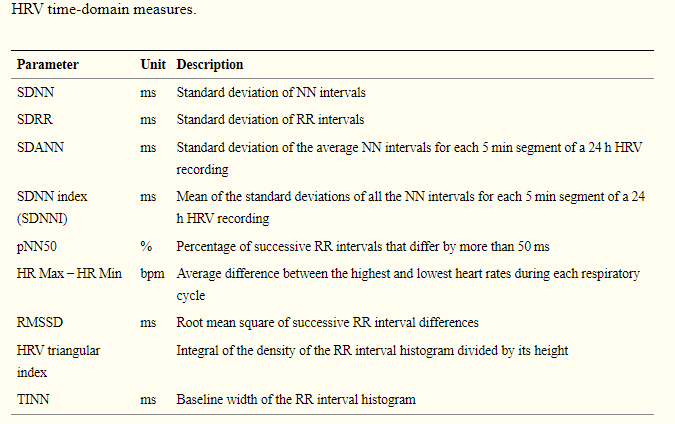 [Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/)

# **Task 4.2**

**Use the time domain features for analysis:**

In [24]:
from hrvanalysis import get_time_domain_features

# PP (ms) correspond to NN intervals
time_domain_features = get_time_domain_features(ppi)
time_domain_features

{'mean_nni': 705.964912280702,
 'sdnn': 201.06732746878276,
 'sdsd': 294.25710679261346,
 'nni_50': 44,
 'pnni_50': 78.57142857142857,
 'nni_20': 52,
 'pnni_20': 92.85714285714286,
 'rmssd': 294.27877939124386,
 'median_nni': 679.9999999999998,
 'range_nni': 880.0000000000009,
 'cvsd': 0.41684618353133435,
 'cvnni': 0.2848120692276494,
 'mean_hr': 91.82586151989484,
 'max_hr': 187.49999999999983,
 'min_hr': 49.99999999999995,
 'std_hr': 25.855513404604622}

In [ ]:
#your code goes here:

Your interesting findings:

# Frequency Domain Analysis

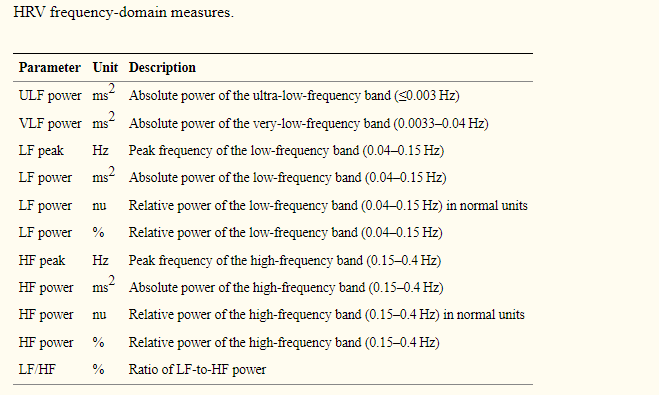[Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/)

In PRV spectral analysis, power spectral density (PSD) can be used to extract low (0,04-0,15 Hz) and high (0,15-0,4 Hz) frequencies. Certain frequency bands correlate with physiological processes, which provide information about the interplay of the autonomic nervous system.

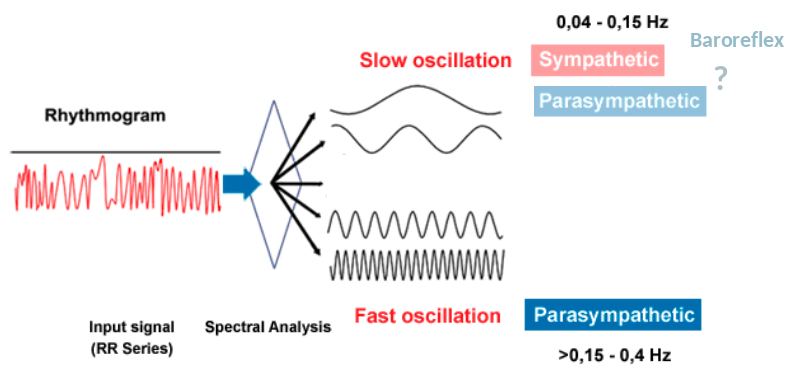

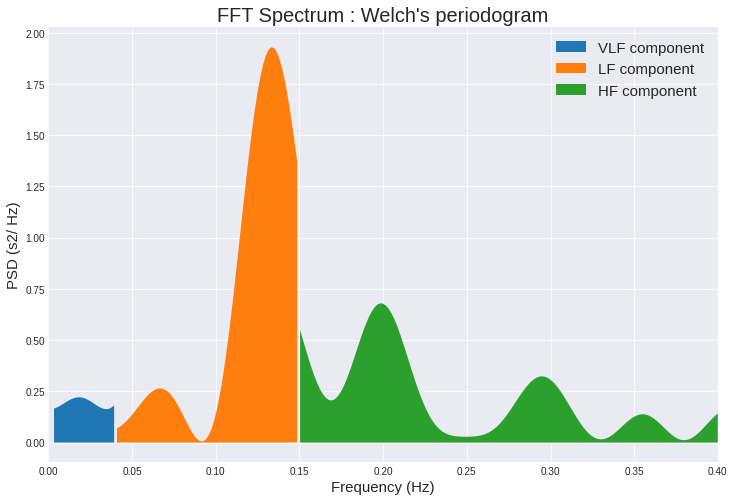

In [25]:
from hrvanalysis import plot_psd
plot_psd(ppi, method="welch")

# **Task 4.3**

**Use the frequency domain features for analysis:**

In [26]:
from hrvanalysis import get_frequency_domain_features

# for unit information look at the figure above with frequency domain measures
frequency_domain_features = get_frequency_domain_features(ppi)
frequency_domain_features

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning:

nperseg = 256 is greater than input length  = 158, using nperseg = 158



{'lf': 4392.0292517133375,
 'hf': 7757.523292567744,
 'lf_hf_ratio': 0.5661638497329698,
 'lfnu': 36.149720211553884,
 'hfnu': 63.850279788446116,
 'total_power': 12269.144622194393,
 'vlf': 119.5920779133124}

In [ ]:
#your code goes here:

Your interesting findings:

For your own interest have a look at a nonlinear method: The Poincaré plot displays the correlation between successive PP intervals.

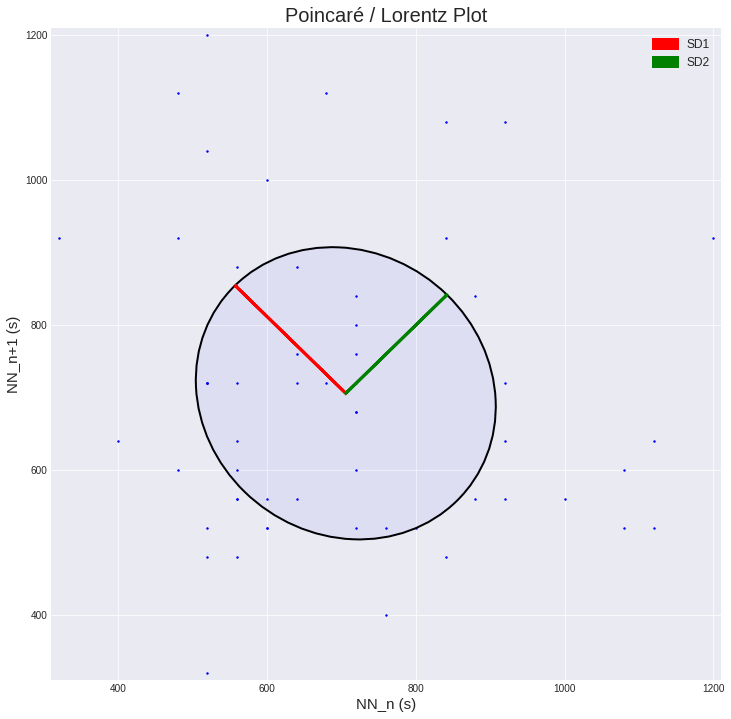

In [27]:
from hrvanalysis import plot_poincare

plot_poincare(ppi)


Additional analysis and findings:

In [ ]:
#your code goes here: